# Analytical approach

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import egttools as egt

In [2]:
# Parameters for the pay-off matrix
## The reward values (prisoner's dilemma)
R_pd = 1
S_pd = -1
T_pd = 2
P_pd = 0
## The reward values (snowdrift)
R_sd = 1
S_sd = 0
T_sd = 2
P_sd = -1
## The values used to calculate the reward for a certain strategy
gamma = 1 # Importance of the game
r = 50 # number of rounds
theta = 3 # trust threshold
p = 0.25 # Chance of checking
epsilon = 0.25 # opportunity cost
# Parameters for the game settings
nb_strategies_with = 5
strategies = ["ALLC","ALLD","TFT","TUC","TUD"]
colors_strat = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple"]
nb_strategies_without = 3
colors_trust = ["tab:orange","tab:blue"]
beta = 0.1 # intensity of selection
Z = 100 # Population size (N)
# boolean to run smaller experiments seperatly
run_small = False
run_big = True

In [3]:
def calculate_pay_off(R,S,T,P,gamma,r,theta,p,epsilon):
    R *= gamma
    S *= gamma
    T *= gamma
    P *= gamma
    # static table
    ## Always cooperate (ALLC)
    ALLC_ALLC = R
    ALLC_ALLD = S
    ALLC_TFT = R
    ALLC_TUC = R
    ALLC_TUD = (theta*R+(r-theta)*S)/r
    ALLC = [ALLC_ALLC,ALLC_ALLD,ALLC_TFT,ALLC_TUC,ALLC_TUD]
    ## Always defect (ALLD)
    ALLD_ALLC = T
    ALLD_ALLD = P
    ALLD_TFT = (T+(r-1)*P)/r
    ALLD_TUC = (T+(r-1)*P)/r
    ALLD_TUD = (T+(r-1)*P)/r
    ALLD = [ALLD_ALLC,ALLD_ALLD,ALLD_TFT,ALLD_TUC,ALLD_TUD]
    ## Tit for Tat (TFT)
    TFT_ALLC = R-epsilon
    TFT_ALLD = (S+(r-1)*P)/r - epsilon
    TFT_TFT = R - epsilon
    TFT_TUD = R - epsilon
    TFT_TUC = (theta*R+S+(r-theta-1)*P)/r - epsilon
    TFT = [TFT_ALLC,TFT_ALLD,TFT_TFT,TFT_TUD,TFT_TUC]
    ## Trust-based Cooperate (TUC)
    TUC_ALLC = R - (theta*epsilon)/r - (p*(r-theta)*epsilon)/r
    TUC_ALLD = (S + (r-1)*P)/r - epsilon
    TUC_TFT = R-(theta*epsilon)/r-(p*(r-theta)*epsilon)/r
    TUC_TUC = R-(theta*epsilon)/r-(p*(r-theta)*epsilon)/r
    TUC_TUD = (theta*R-theta*epsilon)/r + (1/r)*((S*(1-(1-p)**(r-theta)))/p + ((P-epsilon)*((1-p)**(r-theta)+(r-theta)*p - 1))/p)
    TUC = [TUC_ALLC,TUC_ALLD,TUC_TFT,TUC_TUC,TUC_TUD]
    ## Trust-based Defect (TUD)
    TUD_ALLC = (epsilon*R+(r-epsilon)*T-theta*epsilon)/r
    TUD_ALLD = (S+(r-1)*P)/r-epsilon
    TUD_TFT = (theta*R+T+(r-theta-1)*P-theta*epsilon)/r
    TUD_TUC = (theta*R-theta*epsilon)/r + (1/r)*((T*(1 - (1 - p) ** (r - theta)))/p + (P*((1-p)**(r-theta) + (r - theta)*p - 1))/p)
    TUD_TUD = (theta*R+(r - theta) * P - theta*epsilon)/r
    TUD = [TUD_ALLC,TUD_ALLD,TUD_TFT,TUD_TUC,TUD_TUD]
    return np.array([
        ALLC,
        ALLD,
        TFT,
        TUC,
        TUD,])

## run for default parameters
### Prisoner's Dilemma

In [4]:
pay_off_pd = calculate_pay_off(R_pd,S_pd,T_pd,P_pd,gamma,r,theta,p,epsilon)
evolver_pd = egt.analytical.StochDynamics(nb_strategies_with, pay_off_pd, Z)
evolver_pd.mu = 0
stationary_SML_pd = evolver_pd.calculate_stationary_distribution(beta)

In [5]:
print("time spent as Always Cooperate: {} & time spent as Always Cheat: {} & time spent as Tit for Tat: {} & time spent as Trust-based Cooperate {} & time spent as Trust-based Defect {}".format(*stationary_SML_pd))

time spent as Always Cooperate: 0.04444423948049365 & time spent as Always Cheat: 0.2653608065886105 & time spent as Tit for Tat: 0.12223515328999357 & time spent as Trust-based Cooperate 0.3995190913542364 & time spent as Trust-based Defect 0.16844070928666582


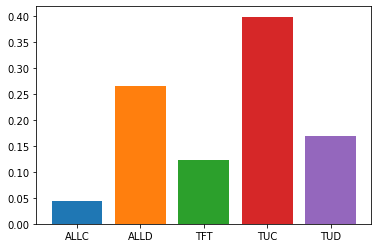

In [6]:
fig_pd,ax_pd = plt.subplots()
ax_pd.bar(strategies,[*stationary_SML_pd],color = colors_strat)
fig_pd.savefig(f'prisoner/default.png')

In [7]:
plt.close(fig_pd)

### Snowdrift

In [8]:
pay_off_sd = calculate_pay_off(R_sd,S_sd,T_sd,P_sd,gamma,r,theta,p,epsilon)
evolver_sd = egt.analytical.StochDynamics(nb_strategies_with, pay_off_sd, Z)
evolver_sd.mu = 0
stationary_SML_sd = evolver_sd.calculate_stationary_distribution(beta)

In [9]:
print("time spent as Always Cooperate: {} & time spent as Always Cheat: {} & time spent as Tit for Tat: {} & time spent as Trust-based Cooperate {} & time spent as Trust-based Defect {}".format(*stationary_SML_sd))

time spent as Always Cooperate: 0.18208775957580695 & time spent as Always Cheat: 0.10520550751886781 & time spent as Tit for Tat: 0.13278599398354254 & time spent as Trust-based Cooperate 0.4869466439199093 & time spent as Trust-based Defect 0.09297409500187344


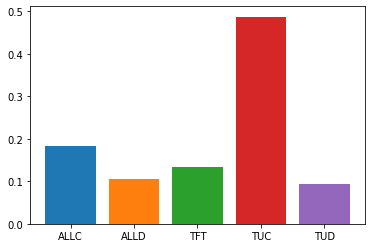

In [10]:
fig_sd,ax_sd = plt.subplots()
ax_sd.bar(strategies,[*stationary_SML_sd],color = colors_strat)
fig_pd.savefig(f'snowdrift/default.png')

In [11]:
plt.close(fig_sd)

# Experiments

## Influence of $\epsilon$

In [12]:
def test_epsilons(R,S,T,P,gamma,r,theta,p,nb_strategies_with,strategies,nb_strategies_without,beta,Z,epsilons):
    # for the frequencies of strategies
    results_with = np.zeros((nb_strategies_with,len(epsilons)))
    # for the frequency of cooperation
    results_without = np.zeros((nb_strategies_without,len(epsilons)))
    for pos in range(len(epsilons)):
        # get the epsilon
        epsilon = epsilons[pos]
        # calculate the pay-offs
        pay_off = calculate_pay_off(R,S,T,P,gamma,r,theta,p,epsilon)
        # for all the strategies
        evolver = egt.analytical.StochDynamics(nb_strategies_with, pay_off, Z)
        evolver.mu = 0
        # calculate the stationary distribution
        stationary_SML = evolver.calculate_stationary_distribution(beta)
        # add the percentage of each strategy and epsilon to the results
        for strategy,v in zip(range(nb_strategies_with),stationary_SML):
            results_with[strategy][pos] = v
        # for all strategies except TUC and TUD
        evolver = egt.analytical.StochDynamics(nb_strategies_without, pay_off, Z)
        evolver.mu = 0
        # calculate the stationary distribution
        stationary_SML = evolver.calculate_stationary_distribution(beta)
        # add the percentage of each strategy and epsilon to the results
        for strategy,v in zip(range(nb_strategies_without),stationary_SML):
            results_without[strategy][pos] = v
    return results_with,results_without

def visualize_epsilons(ax_strat,ax_coop,nb_strategies_with,strategies,colors_strat,nb_strategies_without,colors_trust,epsilons,results_with,results_without):
    # for the frequencies of strategies
    # Plot the line for each of the strategies
    for pos,color_strat in zip(range(nb_strategies_with),colors_strat):
        ax_strat.plot(epsilons,results_with[pos],label = strategies[pos],color = color_strat)
    # Enable the legend of the graph
    ax_strat.legend()
    # Set the limits and labels of the X and Y axis
    ax_strat.set_xlabel("Opportunity cost $\epsilon$")
    ax_strat.set_ylabel("Frequency of Strategy")
    ax_strat.set_xlim(0,1)
    ax_strat.set_ylim(0,1)
    # for the frequency of cooperation
    # Get the values of all the strategies that like to cooperate (without trust)
    without_trust = np.array([results_without[0][pos] + results_without[2][pos] for pos in range(len(epsilons))])
    ax_coop.plot(epsilons,without_trust,label = "without TUC/TUD",color = colors_trust[0])
    # Get the values of all the strategies that like to cooperate (with trust)
    with_trust = np.array([results_with[0][pos] + results_with[2][pos] + results_with[3][pos] for pos in range(len(epsilons))])
    ax_coop.plot(epsilons,with_trust,label = "with TUC/TUD",color = colors_trust[1])
    # Color the area between the two plots in green when the with_trust is above and red when the without_trust is above
    ax_coop.fill_between(epsilons, with_trust, without_trust, where=(with_trust > without_trust), color='green', alpha=0.3)
    ax_coop.fill_between(epsilons, with_trust, without_trust, where=(with_trust < without_trust), color='red', alpha=0.3)
    # Enable the legend of the graph
    ax_coop.legend()
    # Set the limits and labels of the X and Y axis
    ax_coop.set_xlim(0,1)
    ax_coop.set_ylim(0,1)
    ax_coop.set_xlabel("Opportunity cost $\epsilon$")
    ax_coop.set_ylabel("Frequency of Trust")

In [13]:
if run_small:
    # all epsilons we want to test
    epsilons = np.arange(0,1.01,0.01)
    # Calculate the epsilon values
    epsilons_with,epsilons_without = test_epsilons(R_pd,S_pd,T_pd,P_pd,gamma,r,theta,p,nb_strategies_with,strategies,nb_strategies_without,beta,Z,epsilons)
    # create the subplots for the visualisation
    fig_epsilon,(ax_strat_epsilon,ax_coop_epsilon) = plt.subplots(1,2,figsize=(12,5))
    # add the title to the plots
    fig_epsilon.suptitle("Influence of $\epsilon$ where " + r"$\theta$ = " + f"{theta}",size = 20)
    # visualize the results on the subplots
    visualize_epsilons(ax_strat_epsilon,ax_coop_epsilon,nb_strategies_with,strategies,colors_strat,nb_strategies_without,colors_trust,epsilons,epsilons_with,epsilons_without)
    # save the figure
    fig_epsilon.savefig(f'figure/epsilon_theta_{theta}.png')

In [14]:
if run_small:
    # close the plot of the figure of epsilon
    plt.close(fig_epsilon)

## Influence of $\gamma$ and r

In [15]:
def test_gamma_r(R,S,T,P,theta,p,epsilon,nb_strategies_with,nb_strategies_without,beta,Z,gammas,rs):
    # array for the results with the trust-strategies and without the trust-strategies
    results_with_r = []
    results_without_r = []
    # go over every r in the rs
    for r in rs:
        # for the frequencies of strategies
        results_with = np.zeros((nb_strategies_with,len(gammas)))
        # for the frequency of cooperation
        results_without = np.zeros((nb_strategies_without,len(gammas)))
        # go over all the gammas
        for pos in range(len(gammas)):
            # get the gamma
            gamma = gammas[pos]
            # calculate the pay-offs
            pay_off = calculate_pay_off(R,S,T,P,gamma,r,theta,p,epsilon)
            # for all strategies
            evolver = egt.analytical.StochDynamics(nb_strategies_with, pay_off, Z)
            evolver.mu = 0
            # calculate the stationary distribution
            stationary_SML = evolver.calculate_stationary_distribution(beta)
            # store the results
            for strategy,v in zip(range(nb_strategies_with),stationary_SML):
                results_with[strategy][pos] = v
            # for all strategies except TUC and TUD
            evolver = egt.analytical.StochDynamics(nb_strategies_without, pay_off, Z)
            evolver.mu = 0
            # calculate the stationary distribution
            stationary_SML = evolver.calculate_stationary_distribution(beta)
            # safe the result
            for strategy,v in zip(range(nb_strategies_without),stationary_SML):
                results_without[strategy][pos] = v
        # append the results to the global result collection
        results_with_r.append(results_with)
        results_without_r.append(results_without)
    return results_with_r,results_without_r

def visualize_gamma_r(ax_strats,ax_coops,nb_strategies_with,strategies,colors_strat,nb_strategies_without,colors_trust,gammas,rs,results_with_r,results_without_r):
    for r,ax_strat,ax_coop,results_with,results_without in zip(rs,ax_strats,ax_coops,results_with_r,results_without_r):
        # for the frequencies of strategies
        # Plot the line for each of the strategies
        for pos,color_strat in zip(range(nb_strategies_with),colors_strat):
            ax_strat.plot(gammas,results_with[pos],label = strategies[pos])
        ax_strat.legend()
        ax_strat.set_xlabel("importance of the game $\gamma$")
        ax_strat.set_ylabel("Frequency of Strategy")
        ax_strat.set_xlim(0.1,1000)
        ax_strat.set_xscale("symlog")
        ax_strat.set_ylim(0,1)
        # for the frequency of cooperation
        without_trust = np.array([results_without[0][pos] + results_without[2][pos] for pos in range(len(gammas))])
        ax_coop.plot(gammas,without_trust,label = "without TUC/TUD",color = colors_trust[0])
        with_trust = np.array([results_with[0][pos] + results_with[2][pos] + results_with[3][pos] for pos in range(len(gammas))])
        ax_coop.plot(gammas,with_trust,label = "with TUC/TUD",color = colors_trust[1])
        ax_coop.fill_between(gammas, with_trust, without_trust, where=(with_trust > without_trust), color='green', alpha=0.3)
        ax_coop.fill_between(gammas, with_trust, without_trust, where=(with_trust < without_trust), color='red', alpha=0.3)
        ax_coop.legend()
        ax_coop.set_xscale("symlog")
        ax_coop.set_xlim(0.1,1000)
        ax_coop.set_ylim(0,1)
        ax_coop.set_xlabel("importance of the game $\gamma$")
        ax_coop.set_ylabel("Frequency of Trust")
        # add titles
        ax_strat.set_title(f"r = {r}",size = 15)

In [16]:
if run_small:
    gammas = np.geomspace(0.1,1000,100)
    rs = np.array([20,50,100])
    gammas_r_with,gammas_r_without = test_gamma_r(R_pd,S_pd,T_pd,P_pd,theta,p,epsilon,nb_strategies_with,nb_strategies_without,beta,Z,gammas,rs)
    fig_gamma,(ax_strats_gamma,ax_coops_gamma) = plt.subplots(2,3,figsize=(18,10))
    fig_gamma.suptitle("Influence of $\gamma$ and r where " + r"$\theta$ = " + f"{theta}",size=20)
    visualize_gamma_r(ax_strats_gamma,ax_coops_gamma,nb_strategies_with,strategies,colors_strat,nb_strategies_without,colors_trust,gammas,rs,gammas_r_with,gammas_r_without)
    fig_gamma.savefig(f'figure/gamma_and_r_theta_{theta}.png')

In [17]:
if run_small:
    plt.close(fig_gamma)

## Influence of p and $\epsilon$

In [18]:
def test_p_epsilon(R,S,T,P,gamma,r,theta,nb_strategies_with,strategies,nb_strategies_without,beta,Z,ps,epsilons):
    results_with_epsilon = []
    results_without_espilon = []
    for epsilon in epsilons:
        # for the frequencies of strategies
        results_with = np.zeros((nb_strategies_with,len(ps)))
        # for the frequency of cooperation
        results_without = np.zeros((nb_strategies_without,len(ps)))
        for pos in range(len(ps)):
            # for all strategies
            p = 1/ps[pos]
            pay_off = calculate_pay_off(R,S,T,P,gamma,r,theta,p,epsilon)
            evolver = egt.analytical.StochDynamics(nb_strategies_with, pay_off, Z)
            evolver.mu = 0
            stationary_SML = evolver.calculate_stationary_distribution(beta)
            for strategy,v in zip(range(nb_strategies_with),stationary_SML):
                results_with[strategy][pos] = v
            # for all strategies except TUC and TUD
            evolver = egt.analytical.StochDynamics(nb_strategies_without, pay_off, Z)
            evolver.mu = 0
            stationary_SML = evolver.calculate_stationary_distribution(beta)
            for strategy,v in zip(range(nb_strategies_without),stationary_SML):
                results_without[strategy][pos] = v
        results_with_epsilon.append(results_with)
        results_without_espilon.append(results_without)
    return results_with_epsilon,results_without_espilon
                
def visualize_p_epsilon(ax_strats,ax_coops,nb_strategies_with,strategies,colors_strat,nb_strategies_without,colors_trust,ps,epsilons,results_with_epsilon,results_without_epsilon,title_on = False):
    for epsilon,ax_strat,ax_coop,results_with,results_without in zip(epsilons,ax_strats,ax_coops,results_with_epsilon,results_without_epsilon):
        # for the frequencies of strategies
        for pos,color_strat in zip(range(nb_strategies_with),colors_strat):
            ax_strat.plot(ps,results_with[pos],label = strategies[pos],color = color_strat)
        ax_strat.legend()
        ax_strat.set_xlabel("trustfulness $1/p$")
        ax_strat.set_ylabel("Frequency of Strategy")
        ax_strat.set_xlim(0,100)
        ax_strat.set_ylim(0,1)
        # for the frequency of cooperation
        without_trust = np.array([results_without[0][pos] + results_without[2][pos] for pos in range(len(ps))])
        with_trust = np.array([results_with[0][pos] + results_with[2][pos] + results_with[3][pos] for pos in range(len(ps))])
        ax_coop.plot(ps,without_trust,label = "without TUC/TUD",color = colors_trust[0])
        ax_coop.plot(ps,with_trust,label = "with TUC/TUD",color = colors_trust[1])
        ax_coop.fill_between(ps, with_trust, without_trust, where=(with_trust > without_trust), color='green', alpha=0.3)
        ax_coop.fill_between(ps, with_trust, without_trust, where=(with_trust < without_trust), color='red', alpha=0.3)
        ax_coop.legend()
        ax_coop.set_xlim(0,100)
        ax_coop.set_ylim(0,1)
        ax_coop.set_xlabel("trustfulness $1/p$")
        ax_coop.set_ylabel("Frequency of Trust")
        # add titles
        ax_strat.set_title(f"epsilon = {epsilon}",size = 15)

In [19]:
if run_small:
    ps = np.arange(1,101,1)
    epsilons = np.array([0,0.2,0.5])
    ps_epsilon_with,ps_epsilon_without = test_p_epsilon(R_pd,S_pd,T_pd,P_pd,gamma,r,theta,nb_strategies_with,strategies,nb_strategies_without,beta,Z,ps,epsilons)
    fig_p,(ax_strats_p,ax_coops_p) = plt.subplots(2,3,figsize=(18,10))
    fig_p.suptitle("Influence of p and $\epsilon$ where " + r"$\theta$ = " + f"{theta}",size=20)
    visualize_p_epsilon(ax_strats_p,ax_coops_p,nb_strategies_with,strategies,colors_strat,nb_strategies_without,colors_trust,ps,epsilons,ps_epsilon_with,ps_epsilon_without)
    fig_p.savefig(f'figure/p_and_epsilon_theta_{theta}.png')

In [20]:
if run_small:
    plt.close(fig_p)

## Do the previous experiments for different $\theta$

In [21]:
def test_theta(R,S,T,P,gamma,r,p,epsilon,nb_strategies_with,strategies,colors_strat,nb_strategies_without,colors_trust,beta,Z,thetas,path):
    for theta in thetas:
        ### epsilons
        epsilons = np.arange(0,1.1,0.1)
        epsilons_with,epsilons_without = test_epsilons(R,S,T,P,gamma,r,theta,p,nb_strategies_with,strategies,nb_strategies_without,beta,Z,epsilons)
        fig_epsilon,(ax_strat_epsilon,ax_coop_epsilon) = plt.subplots(1,2,figsize=(12,5))
        fig_epsilon.suptitle("Influence of $\epsilon$ where " + r"$\theta$ = " + f"{theta}",size = 20)
        visualize_epsilons(ax_strat_epsilon,ax_coop_epsilon,nb_strategies_with,strategies,colors_strat,nb_strategies_without,colors_trust,epsilons,epsilons_with,epsilons_without)
        fig_epsilon.savefig(f'{path}/epsilon_theta_{theta}.png')
        plt.close(fig_epsilon)
        ### gamma and r
        gammas = np.geomspace(0.1,1000,100)
        rs = np.array([20,50,100])
        gammas_r_with,gammas_r_without = test_gamma_r(R,S,T,P,theta,p,epsilon,nb_strategies_with,nb_strategies_without,beta,Z,gammas,rs)
        fig_gamma,(ax_strats_gamma,ax_coops_gamma) = plt.subplots(2,3,figsize=(18,10))
        fig_gamma.suptitle("Influence of $\gamma$ and r where " + r"$\theta$ = " + f"{theta}",size=20)
        visualize_gamma_r(ax_strats_gamma,ax_coops_gamma,nb_strategies_with,strategies,colors_strat,nb_strategies_without,colors_trust,gammas,rs,gammas_r_with,gammas_r_without)
        fig_gamma.savefig(f'{path}/gamma_theta_{theta}.png')
        plt.close(fig_gamma)
        ### p and epsilon
        ps = np.arange(1,101,1)
        epsilons = np.array([0,0.2,0.5])
        ps_epsilon_with,ps_epsilon_without = test_p_epsilon(R,S,T,P,gamma,r,theta,nb_strategies_with,strategies,nb_strategies_without,beta,Z,ps,epsilons)
        fig_p,(ax_strats_p,ax_coops_p) = plt.subplots(2,3,figsize=(18,10))
        fig_p.suptitle("Influence of p and $\epsilon$ where " + r"$\theta$ = " + f"{theta}",size=20)
        visualize_p_epsilon(ax_strats_p,ax_coops_p,nb_strategies_with,strategies,colors_strat,nb_strategies_without,colors_trust,ps,epsilons,ps_epsilon_with,ps_epsilon_without)
        fig_p.savefig(f'{path}/p_and_epsilon_theta_{theta}.png')
        plt.close(fig_p)

In [22]:
if run_big:
    thetas = [3,5,10]
    test_theta(R_pd,S_pd,T_pd,P_pd,gamma,r,p,epsilon,nb_strategies_with,strategies,colors_strat,nb_strategies_without,colors_trust,beta,Z,thetas,"prisoner")

# snowdrift

In [23]:
if run_big:
    thetas = [3,5,10]
    test_theta(R_sd,S_sd,T_sd,P_sd,gamma,r,p,epsilon,nb_strategies_with,strategies,colors_strat,nb_strategies_without,colors_trust,beta,Z,thetas,"snowdrift")

TypeError: test_theta() missing 2 required positional arguments: 'thetas' and 'path'